In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Load the dataset from Hugging Face
dataset = load_dataset('ta4tsering/Lhasa_kanjur_transcription_datasets', split='test')

# Load the pre-trained RoBERTa model and tokenizer
model_name = 'openpecha/tibetan_RoBERTa_S_e6'
tokenizer = AutoTokenizer.from_pretrained(model_name)
roberta_model = AutoModel.from_pretrained(model_name)

# Function to convert text to vector using the RoBERTa model
def text_to_vector(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = roberta_model(**inputs)
    return torch.mean(outputs.last_hidden_state, dim=1)  # Use mean pooling

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_dir, filename_to_transcription):
        self.image_dir = image_dir
        self.filename_to_transcription = filename_to_transcription
        self.image_filenames = [f for f in os.listdir(image_dir) if f in filename_to_transcription]
        self.transform = transforms.Compose([
            transforms.Resize((64, 2048)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        transcription = self.filename_to_transcription[filename]
        vector = text_to_vector(transcription)
        image_path = os.path.join(self.image_dir, filename)
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        image = self.transform(image)
        return image, vector

# Prepare the dataset: Map filenames to transcriptions
image_dir = '/Selected_LG'
filename_to_transcription = {row['filename']: row['label'] for row in dataset}

# Create DataLoader
dataset = CustomDataset(image_dir, filename_to_transcription)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

Some weights of RobertaModel were not initialized from the model checkpoint at openpecha/tibetan_RoBERTa_S_e6 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNetConditional(nn.Module):
    def __init__(self):
        super(UNetConditional, self).__init__()

        # Encoder
        self.inc = DoubleConv(2, 64)  # Noise and condition
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, 1, kernel_size=1)

        self.condition_embed = nn.Linear(768, 64 * 2048)

    def forward(self, noise, condition):
        batch_size = noise.size(0)

        # Embed condition vector and reshape to match the target image shape
        cond_embed = self.condition_embed(condition)
        cond_embed = cond_embed.view(batch_size, 1, 64, 2048)

        # Concatenate noise and condition
        x = torch.cat([noise, cond_embed], dim=1)

        # Encode
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decode
        x = self.up1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.conv1(x)
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.conv2(x)
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv3(x)
        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv4(x)
        x = self.outc(x)
        return x


In [ ]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetConditional().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

epochs = 50
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    epoch_loss = 0
    for images, conditions in dataloader:
        images, conditions = images.to(device), conditions.to(device)

        # Generate random noise with the same dimensions as the images
        noise = torch.randn(images.size(0), 1, 64, 2048).to(device)

        # Forward pass
        outputs = model(noise, conditions)
        loss = criterion(outputs, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f'Epoch Loss: {epoch_loss/len(dataloader)}')


Epoch 1/50


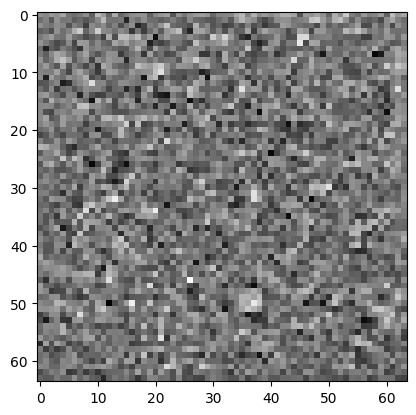

In [33]:
# Function to generate images from noise and condition
def generate_images(model, condition_vector):
    model.eval()
    with torch.no_grad():
        noise = torch.randn(1, 1, 64, 64).to(device)
        generated_image = model(noise, condition_vector)
        return generated_image

# Example usage: Generate an image from a random condition vector
example_condition_vector = dataset[0][1].unsqueeze(0).to(device)  # Use a condition vector from the dataset
generated_image = generate_images(model, example_condition_vector)
generated_image = generated_image.squeeze().cpu().numpy()

# Visualize the generated image
plt.imshow(generated_image, cmap='gray')
plt.show()